# Проект 10. Прогнозирование заказов такси.

**Описание проекта:**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

**Цель проекта:**

Построить модель для прогнозирования заказов такси на следующий час.

**Задачи проекта:**
1. Подготовить и проанализировать предоставленные компанией данные по заказам
2. Построить несколько моделей для прогнозирования заказов
3. Отобрать лучшую модель (метрика RMSE лучшей модели на тестовых данных не больше 48)

**План работы:**


1. Загрузка данных, изучение первичной информации.
2. Предварительная обработка и исследование данных.
3. Прогнозирование временного ряда
   - 3.1. Добавление новых признаков
   - 3.2. Проверка линейной модели
   - 3.3. Проверка дерева решений
   - 3.4. Проверка CatBoost
4. Вывод.

## 1. Загрузка данных, изучение первичной информации.

In [1]:
! pip install -U scikit-learn -q
! pip install catboost -q

In [2]:
# Загрузим необходимые для работы библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels. tsa.stattools import adfuller

from sklearn.linear_model import  LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.dummy import DummyRegressor

from numpy.random import RandomState
from catboost import CatBoostRegressor

In [3]:
# Откроем файл taxi.csv, индексом сделаем столбец с датой, индексы отсортируем по возрастанию

try:
    taxi = pd.read_csv('/datasets/taxi.csv', parse_dates = ['datetime'], index_col = ['datetime'])
except:
    taxi = pd.read_csv('taxi.csv', parse_dates = ['datetime'], index_col = ['datetime'])
taxi.sort_index(inplace=True)    
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# Вызовем общую информацию о таблице
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В нашей таблице 26496 строк. В столбце num_orders находится количество заказов. Данные представлены за период с 1 марта 2018 года по 31 августа 2018 года. Данные предоставлены с 10-минутным интервалом.

## 2. Предварительная обработка и исследование данных.

Нашей задачей является прогнозирование количества заказов на последующий час, поэтому выполним почасовое ресемплирование предоставленных данных. Агрегировать значение будем по сумме.

In [5]:
taxi = taxi.resample('1H').sum() 
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


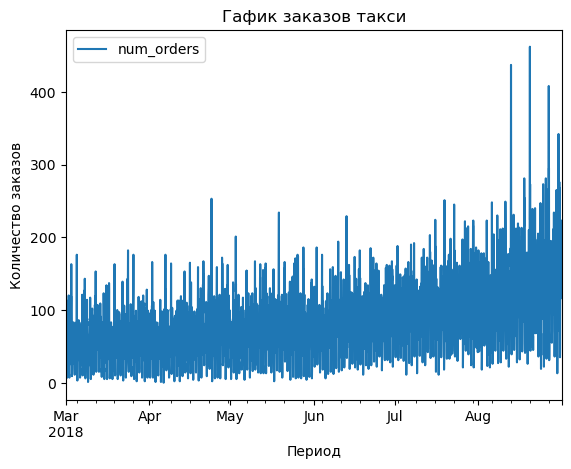

In [6]:
# Построим график по нашим данным
taxi.plot()
plt.title ('Гафик заказов такси')
plt.xlabel('Период')
plt.ylabel('Количество заказов');

Основной объем заказов размещается в промежутке 5-100, но есть и скачки свыше 400 заказов в час.
Добавим в наш график скользящее среднее. Размер окна пока установим равным 10.

In [7]:
taxi['rolling_mean'] = taxi['num_orders'].shift().rolling(15).mean()
taxi['std'] = taxi['num_orders'].shift().rolling(15).std()

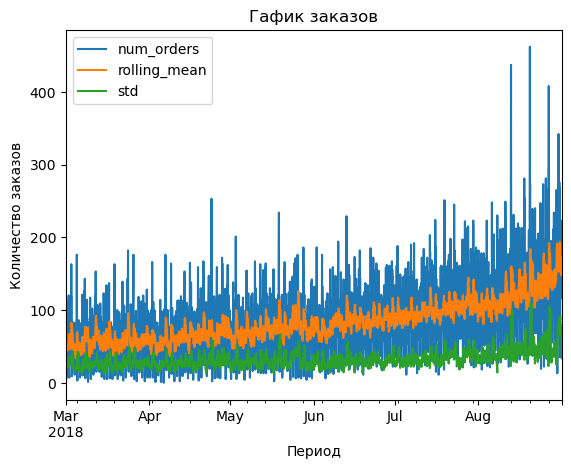

In [8]:
taxi.plot()
plt.title ('Гафик заказов')
plt.xlabel('Период')
plt.ylabel('Количество заказов');

Значения скользящего среднего и скользящего стандартного отклонения колеблются меньше, чем общее количество заказов. По графику кажется, что скользящее среднее и стандартное отклонение не стабильны и постоянно меняются, то есть наш временной ряд не стационарен. Проверим нашу гипотезу с помощью теста Дики-Фуллера.

Сделаем тест Дики-Фуллера, чтобы проверить стационарность нашего временного ряда.
Сформулируем гипотезы для проверки:

- H0: временной ряд нестационарен (имеет единичный корень), заказы на такси зависят от времени, имеют тренд и сезонность.
- H1: временной ряд стационарен (не имеет единичного корня), заказы на такси не меняются во времени.

Результат теста сравним со значениями alpha 1% и 5%, чтобы быть уверенными в результатах.

In [9]:
test = adfuller(taxi['num_orders'])
print('adf:', test[0])
print('p_value:', test[1])
print('Critical values:', test[4])
if test[0] > test[4]['5%']:
    print('p-value > 5%, есть единичные корни, ряд не стационарен')
elif test[0] > test[4]['1%']:
    print('p-value > 1%, есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf: -3.0689242890279513
p_value: 0.02894005140261326
Critical values: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
p-value > 1%, есть единичные корни, ряд не стационарен


При проверке тестом Дики-Фуллера подтвердилась нестационарность нашего ряда при уровне значимости 1%. Эту особенность наших данных необходимо будет учесть при прогнозировании.  

Построим новый график с учетом скользящего среднего, но возьмем небольшой период - в одну неделю. Например с 12 по 19 апреля.

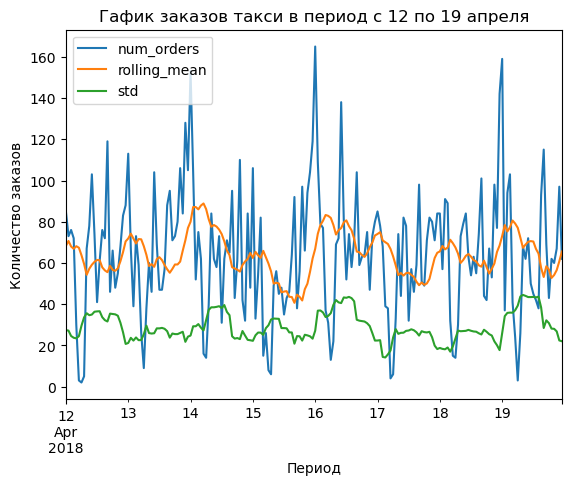

In [10]:
taxi['2018-04-12':'2018-04-19'].plot()
plt.title ('Гафик заказов такси в период с 12 по 19 апреля')
plt.xlabel('Период')
plt.ylabel('Количество заказов');

На более коротком промежутке стали яснее видны пики и провалы в заказах. Так как нас интересует почасовое предсказние объемов, то интересно было бы посмотреть на такой график в разрезе одного дня.

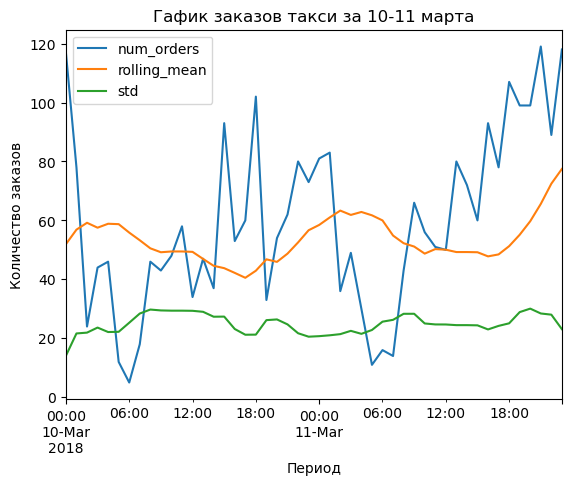

In [11]:
taxi['2018-03-10':'2018-03-11'].plot()
plt.title ('Гафик заказов такси за 10-11 марта')
plt.xlabel('Период')
plt.ylabel('Количество заказов');

На графике появились пики в дневное и вечернее время и провалы в утренние часы. Скользящее среднее и скользящее стандартное отклонение в пределах одного дня выглядят более стабильными.

Посмотрим на тренды и сезонность нашего временного ряда.

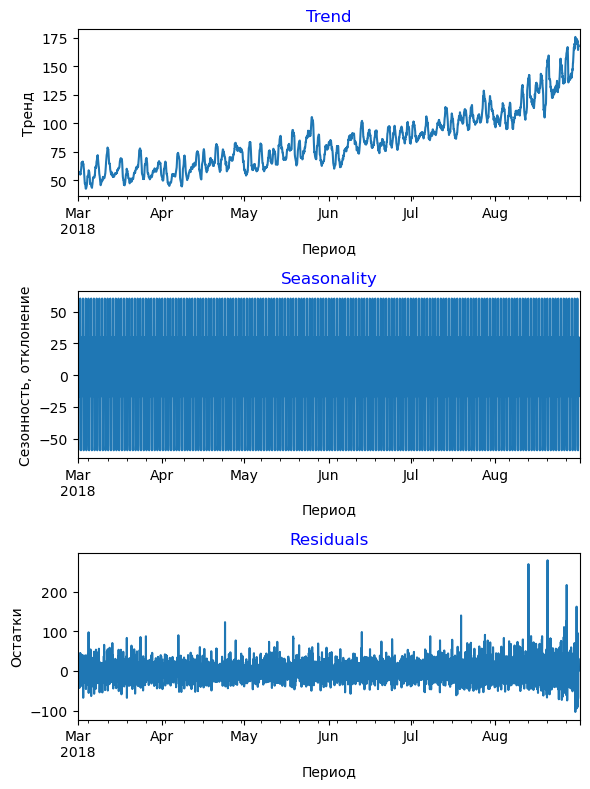

In [12]:
decomposed = seasonal_decompose(taxi['num_orders'])
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend', color = 'blue', fontsize = 12)
plt.xlabel ('Период')
plt.ylabel ('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality', color = 'blue', fontsize = 12)
plt.xlabel ('Период')
plt.ylabel ('Сезонность, отклонение')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals', color = 'blue', fontsize = 12)
plt.xlabel ('Период')
plt.ylabel ('Остатки')
plt.tight_layout()


По графику виден тренд на увеличение количества вызовов в летние месяцы. Сезонность на этом периоде установить не возможно. Посмотрим ее на промежутке в 5 дней.

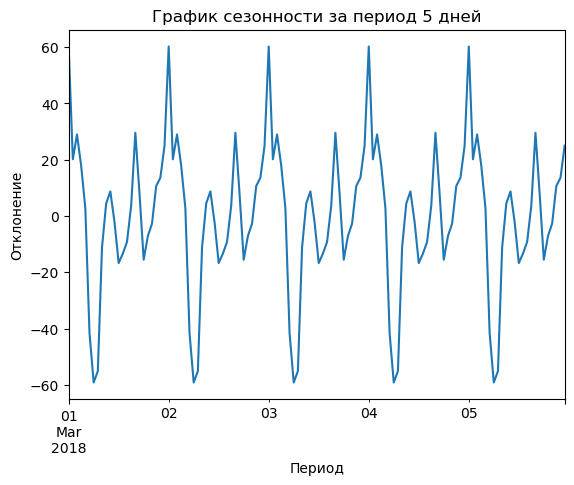

In [13]:
decomposed.seasonal['2018-03-01':'2018-03-05'].plot()
plt.title('График сезонности за период 5 дней')
plt.xlabel('Период')
plt.ylabel('Отклонение');

По графику видны спады активности в заказах в утренние часы и пики в ночные.  


## 3. Прогнозирование временного ряда.

### 3.1. Создание новых признаков.

Первым шагом напишем функцию для создания новых признаков в наших данных. В качестве календарных признаков возьмем месяц, день, день недели и час, добавим скользящее среднее с возможностью изменения окна и отстающие значения с возможностью корректировки их количества.

In [14]:
# напишем функцию для создания дополнительных признаков:

def make_features(data, max_lag, rolling_mean_size):
    new_data = data.copy()
    new_data['day'] = data.index.day
    new_data['dayofweek'] = data.index.dayofweek
    new_data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    new_data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return new_data

In [15]:
#Проверим работу функции и зададим набор признаков

taxi_new = make_features(taxi, 20, 10)
taxi_new.head()

,num_orders,rolling_mean,std,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,...,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,1,3,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,1,3,1,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,1,3,2,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,1,3,3,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN,1,3,4,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.2. Проверка линейной модели.

Начнем подбор моделей с простейшей модели линейной регрессии. Для ее работы разделим нашу выборку на три части: тренировочную и тестовую в отношении 9:1.

In [16]:
train, test = train_test_split(taxi_new, shuffle =False, test_size = 0.1)
train = train.dropna() 
train.shape, test.shape

((3954, 26), (442, 26))

In [17]:
#Проверим, корректно ли прошло разделение выборок

train.index.min(), train.index.max(), test.index.min(), test.index.max()

(Timestamp('2018-03-01 20:00:00'),
 Timestamp('2018-08-13 13:00:00'),
 Timestamp('2018-08-13 14:00:00'),
 Timestamp('2018-08-31 23:00:00'))

Тренировочная выборка заканчивается 13 часами 13 августа и тестовая начинается 14 часами 13 августа - выборки разделились корректно. Теперь выделим целевой и входящий признаки.

In [18]:
X_train = train.drop('num_orders', axis=1)
X_test = test.drop('num_orders', axis=1)
y_train = train['num_orders']
y_test = test['num_orders']

In [19]:
# для кросс-валидации зададим TimeSeriesSplit, так как нам важно, 
# чтобы тренировочные временные данные предшествовали валидационным 

tss=TimeSeriesSplit(n_splits = 5)

In [20]:
#Зададим модель линейной регрессии и посмотрим на значение метрики
model_1 = LinearRegression()
parameters ={}
gs_lr=GridSearchCV(
model_1,
parameters,
cv = tss,
n_jobs =-1,
scoring='neg_root_mean_squared_error')

In [21]:
gs_lr.fit(X_train,y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LinearRegression(), n_jobs=-1, param_grid={},
             scoring='neg_root_mean_squared_error')

In [41]:
print ('Метрика линейной модели при кросс-валидации:', (-round(gs_lr.best_score_)))

Метрика линейной модели при кросс-валидации: 32


RMSE линейной модели при кросс-валидации равно 32. Теперь проверим, как сработает дерево решений.

### 3.3. Проверка дерева решений.

Перебор гиперпараметров DecisionTreeRegressor будем осуществлять через GridSearchCV на кросс-валидации, поэтому выделение валидационной выборки в этом случае не потребуется. Выделим целевой и входящий признаки на первоначальной тестовой выборке.

In [23]:
#Зададим random_state

RANDOM_STATE = 15


In [24]:
model_2 = DecisionTreeRegressor(random_state=RANDOM_STATE)

In [25]:
# Задаем параметры для перебора 
parameters = {
    'min_samples_leaf': range(1, 8),
    'min_samples_split': range(2, 5),
    'max_depth': range(2, 9)
}

In [26]:
grid_search = GridSearchCV(
model_2,
parameters,
cv = tss,
n_jobs =-1,
scoring='neg_root_mean_squared_error')

In [27]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DecisionTreeRegressor(random_state=15), n_jobs=-1,
             param_grid={'max_depth': range(2, 9),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 5)},
             scoring='neg_root_mean_squared_error')

In [28]:
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на при кросс-валидации:', (-round(grid_search.best_score_)))

Лучшая модель и её параметры:

 DecisionTreeRegressor(max_depth=8, min_samples_leaf=7, random_state=15)
Метрика лучшей модели на при кросс-валидации: 30


Метрика RMSE лучшей модели дерева решений при крос-валидации равна 30. Теперь посмотрим, как сработает модель градиентного бустинга из библиотеки CatBoost.

### 3.3. Проверка CatBoost

Зададим модель CatBoostRegressor с 50 деревьями, ее параметры так же будем перебирать через GridSearchCV. В качестве параметров для перебора возьмем максимальную глубину деревьев и коэффициэнт скорости обучения.

In [29]:
model_3 = CatBoostRegressor(random_state = RANDOM_STATE, iterations = 50)

In [30]:
params = {'depth':[6,8,10],
         'learning_rate':[0.03,0.5,0.1]}

In [31]:
gs = GridSearchCV(
model_3,
params,
cv = tss,
n_jobs =-1,
scoring='neg_root_mean_squared_error')

In [32]:
gs.fit(X_train, y_train)

0:	learn: 30.5382826	total: 178ms	remaining: 8.74s
1:	learn: 26.6877760	total: 260ms	remaining: 6.23s
2:	learn: 24.5907496	total: 288ms	remaining: 4.51s
3:	learn: 23.4984275	total: 312ms	remaining: 3.59s
4:	learn: 23.2354328	total: 356ms	remaining: 3.2s
5:	learn: 22.6326169	total: 408ms	remaining: 2.99s
6:	learn: 22.2308699	total: 494ms	remaining: 3.03s
7:	learn: 22.1533045	total: 530ms	remaining: 2.78s
8:	learn: 21.6553322	total: 553ms	remaining: 2.52s
9:	learn: 21.2934082	total: 638ms	remaining: 2.55s
10:	learn: 20.8984339	total: 673ms	remaining: 2.39s
11:	learn: 20.3658519	total: 697ms	remaining: 2.21s
12:	learn: 20.0918986	total: 787ms	remaining: 2.24s
13:	learn: 19.8544593	total: 836ms	remaining: 2.15s
14:	learn: 19.4268082	total: 871ms	remaining: 2.03s
15:	learn: 19.0652463	total: 943ms	remaining: 2s
16:	learn: 18.8958565	total: 1s	remaining: 1.95s
17:	learn: 18.5191573	total: 1.03s	remaining: 1.83s
18:	learn: 18.3850139	total: 1.05s	remaining: 1.72s
19:	learn: 18.2179084	total: 

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x00000263683A2390>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10],
                         'learning_rate': [0.03, 0.5, 0.1]},
             scoring='neg_root_mean_squared_error')

In [33]:
print('Лучшая модель и её параметры:\n\n', gs.best_estimator_)
print ('Метрика лучшей модели на при кросс-валидации:', (-round(gs.best_score_)))

Лучшая модель и её параметры:

Метрика лучшей модели на при кросс-валидации: 27


Метрика RMSE CatBoost при кросс-валидации равна 27 - это лучший результат из трех моделей. Проверим значения лучшей модели на тестовой выборке.

In [34]:
y_pred = gs.best_estimator_.predict(X_test)
print('RMSE лучшей модели на тестовых данных равен', round(mean_squared_error(y_test, y_pred, squared =False)))

RMSE лучшей модели на тестовых данных равен 44


C:\Users\Роман Полицинский\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Проверим эффективность работы лучшей модели, сравнив ее предсказания с предсказаниями константной модели DummyRegressor()

In [35]:
model_dummy = DummyRegressor(strategy='mean')
model_dummy.fit(X_train, y_train)
pred_dummy = model_dummy.predict(X_test)
print('RMSE константной модели на тестовых данных:', round(mean_squared_error(y_test, pred_dummy, squared=False)))

RMSE константной модели на тестовых данных: 85


C:\Users\Роман Полицинский\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE константной модели на тестовых данных равно 85, получается, что наша лучшая модель, основанная на градиентном бустинге, сработала и предсказывает значения лучше константы.

In [36]:
# Преобразуем предсказания в таблицу
column = ['predictions']
y_pred = pd.DataFrame(y_pred, columns = column)
y_pred.head()

,predictions
0,100.052580
1,104.473846
2,131.609660
3,141.399970
4,100.809579


In [37]:
#Объединим таблицы с предсказанием и тестовым значением в одну таблицу
taxi_preds = y_test.reset_index()
taxi_preds = pd.concat([taxi_preds, y_pred], axis=1).set_index('datetime')
taxi_preds.head()

,num_orders,predictions
datetime,,
2018-08-13 14:00:00,102,100.052580
2018-08-13 15:00:00,175,104.473846
2018-08-13 16:00:00,144,131.609660
2018-08-13 17:00:00,152,141.399970
2018-08-13 18:00:00,104,100.809579


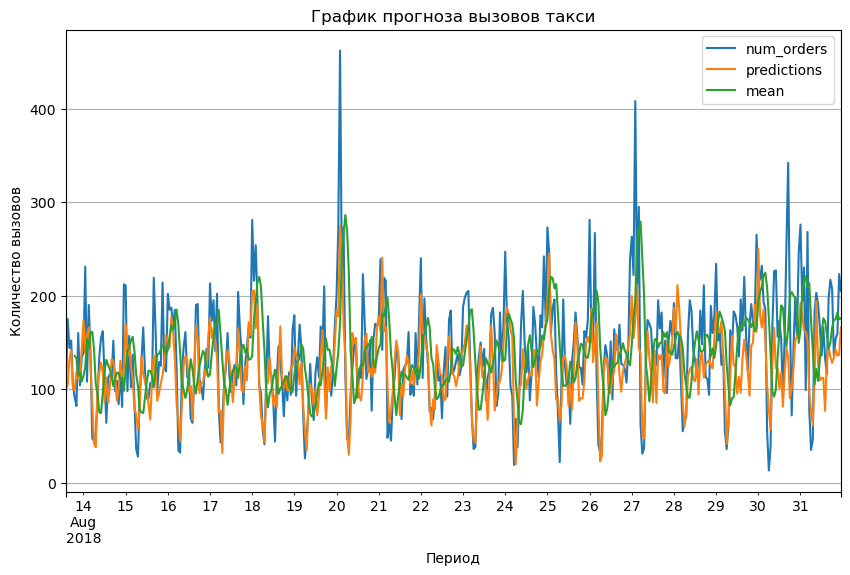

In [38]:
#Построим график
taxi_preds['mean']=taxi_preds['num_orders'].shift().rolling(5).mean()
taxi_preds.plot(figsize = (10,6), grid=True)
plt.title("График прогноза вызовов такси")
plt.xlabel('Период')
plt.ylabel('Количество вызовов');

На графике видно, что наша модель неплохо справляется с предсказаниями, если они не сильно отклоняются от скользящего среднего. В случае больших отклонений от скользящего среднего - в основном это скачки в увеличении количества заказов, модель срабатывает хуже и ее предсказания меньше реальных значений.

## 4. Вывод.

В ходе проделанной работы мы провели предварительное исследование предоставленных данных. У нас были данные по вызовам такси за период с 1 марта по 31 августа 2018 года с 10-ти минутным интервалом. Так как нас предстояло построить модель для предсказания вызовов на следующий час, логично было сделать почасовое сэмплирование предоставленных данных. 

По графикам тренда и сезонности был отслежен тренд на увеличение количества заказо в в летние месяцы, а сезонность показала увеличение количества заказов в вечерние и ночные часы и спады в утренние часы.

Для прогнозирования временного ряда мы добавили три вида признаков в наши данные. В качестве календарных признаков были добавлены  день месяца, день недели и час, добавлено скользящее среднее с окном равным 10 и "отстающие значения" в количестве 20.

Для предсказания временного ряда было проверено три модели.

Модель линейной регрессии на тренировочной выборке показала метрику RMSE равную 31. Перебор гиперпарметров дерева решений осуществлялся через GridSearchCV с помощью метода кросс-валидации для временных рядов - TimeSeriesSplit. RMSE лучшeй модели DecisionTreeRegressor на кросс-валидации был равен 30. Третьей моделью была выбрана модель градиентного бустинга CatBoostRegressor с 50 деревьями, перебор ее гиперпараметров так же осуществлялся через GridSearchCV и TimeSeriesSplit. RMSE лучшей модели на кросс-валидации составил 27. 

Таким образом лучшей моделью оказалась модель CatBoostRegressor - эту модель мы проверили на тестовых данных. Значение RMSE на тестовых данных равно 44.
Для проверки адекватности работы лучшей модели мы сравнили ее предсказания с предсказаниями константной модели DummyRegressor. Метрика RMSE константной модели на тестовых равна 85, что говорит о том, что модель CatBoostRegressor сработала достаточно эффективно.
При визуализации предсказаний лучшей модели и сравнении их с тестовыми значениями обозначились "слабые места" в ее работе: модель хорошо справляется с предсказаниями, если они не сильно отклоняются от стандарного среднего, но не может справиться с предсказанием выбросных значений на увеличение количества заказов - она предсказывает значения ниже реального.